<font size = 8> Barnacle detenction using Image Processing. 

<font size=4> In this notebook, I explore traditional computer vision and image processing techniques to develop a pipeline for counting barnacles. The process involves a sequence of steps including filtering, binarization, morphological transformations, and contour detection.

I also implement popular methods such as Otsu's thresholding for binarization and the Watershed algorithm for image segmentation. Finally, by identifying and counting the distinct contour objects, I estimate the number of barnacles in the given image.

<font size = 5> Importing necessary libraries

In [74]:
import numpy as np
import cv2
from matplotlib import pyplot as plt 
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
from PIL import Image

<font size= 5> Grayscaling the image and reducing noise 

<font size=4> The following pipeline is demonstrated using one of the images provided for the challenge. Feel free to test it on other images as well. However, a quick disclaimer: since this technique is entirely manual and does not leverage any state-of-the-art computer vision models specifically trained to count barnacles, it may produce false positives on images that do not contain barnacles. This pipeline assumes that the input images, like those provided in the challenge, consist solely of barnacle-covered surfaces.

In [75]:
THRESHOLD =0.27 #Optimal threshold decided based on a manual grid search across 20+ different values
image_path = "sample_image"

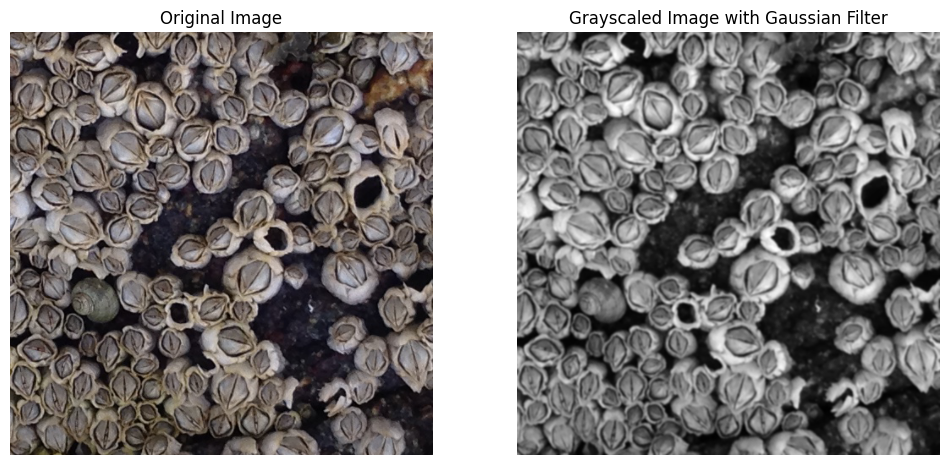

In [67]:
image = Image.open(image_path).convert("RGB")
grayscale_image = image.convert("L")
image_array = np.array(grayscale_image)
gaussian_filtered_image = gaussian_filter(image_array, sigma=1)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].imshow(image)
ax[0].set_title('Original Image')
ax[0].axis('off')

ax[1].imshow(gaussian_filtered_image, cmap= 'gray')
ax[1].set_title('Grayscaled Image with Gaussian Filter')
ax[1].axis('off')

plt.show()

<font size= 6> Applying Otsu's Thresholding

<font size = 4>Otsu's method is a popular algorithm for automatic image thresholding. The 'optimal' threshold calulcated using Otsu's method is used to convert a grayscale image into a binary image.

Obtained threshold: 84.0


(np.float64(-0.5), np.float64(499.5), np.float64(499.5), np.float64(-0.5))

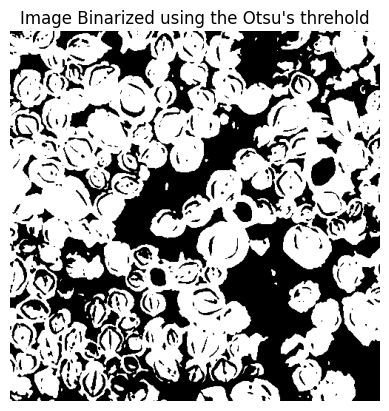

In [78]:
otsu_threshold, image_after_otsu = cv2.threshold(
gaussian_filtered_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU, 
)
print("Obtained threshold:", otsu_threshold)

plt.imshow(image_after_otsu, cmap= 'gray')
plt.title("Image Binarized using the Otsu's threhold")
plt.axis('off')


<font size =5> Removing noise

(np.float64(-0.5), np.float64(499.5), np.float64(499.5), np.float64(-0.5))

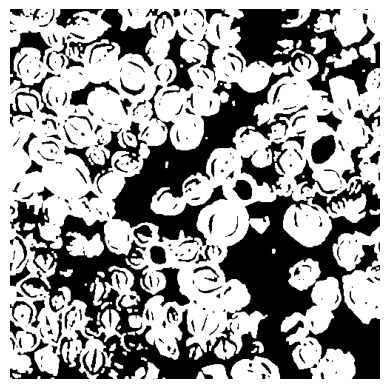

In [ ]:
# noise removal
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
cleaned_image = cv2.morphologyEx(image_after_otsu, 
                           cv2.MORPH_OPEN,
                           kernel,
                           iterations=1)
plt.imshow(cleaned_image, cmap='gray')
<>plt.axis('off')

<font size=5> Morphological Transformations

<font size=4> Several morphological operations are applied to the image. First, erosion is used to shrink objects and eliminate noise. Then, dilation is performed to expand the remaining structures.

After these steps, a distance transform is applied to compute the distance of each white pixel from the nearest black pixel. This distance map helps distinguish the definite foreground area from the uncertain region, which is useful for segmentation tasks. The threshold value used to separate these areas is 0.27, chosen after performing a grid search over more than 20 different threshold values.

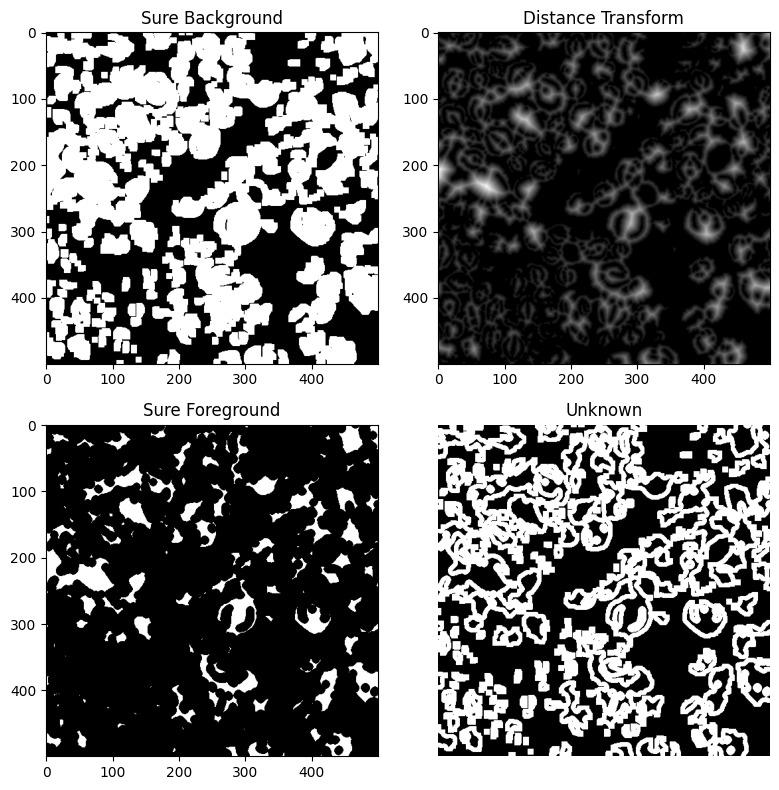

In [70]:
# Create subplots with 2 rows and 2 columns
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))

# sure background area
intermediary_bg = cv2.erode(cleaned_image, kernel, iterations=3)
sure_bg = cv2.dilate(intermediary_bg, kernel, iterations=4)
axes[0,0].imshow(sure_bg, cmap='gray') # Corrected line
axes[0, 0].set_title('Sure Background')

# Distance transform
dist = cv2.distanceTransform(cleaned_image, cv2.DIST_L2,5)
axes[0,1].imshow(dist, cmap='gray') # Corrected line
axes[0, 1].set_title('Distance Transform')

# foreground area
ret, sure_fg = cv2.threshold(dist, THRESHOLD * dist.max(), 255, cv2.THRESH_BINARY)
sure_fg = sure_fg.astype(np.uint8)
axes[1,0].imshow(sure_fg, cmap='gray') # Corrected line
axes[1, 0].set_title('Sure Foreground')

# unknown area
unknown = cv2.subtract(sure_bg, sure_fg)
axes[1,1].imshow(unknown, cmap='gray') # Corrected line
axes[1, 1].set_title('Unknown')

plt.tight_layout() # Adjust layout to prevent titles/labels from overlapping
plt.axis('off')
plt.show()

<font size = 5> Creating Marker Image

<font size=4> Now, each distinct object identified in the sure-foreground image is assigned a unique marker. After that, all marker values are incremented by 1, which is a common practice to reserve the value 0 for the unknown region when applying the Watershed algorithm. 

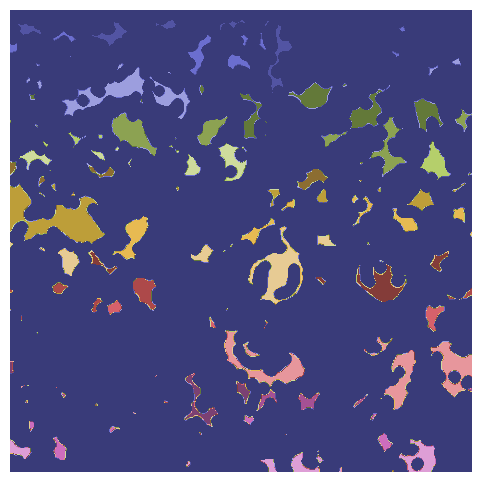

In [71]:
# Marker labelling
# sure foreground 
ret, markers = cv2.connectedComponents(sure_fg)

# Add one to all labels so that background is not 0, but 1
markers += 1
# mark the region of unknown with zero
markers[unknown == 255] = 0

fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(markers, cmap="tab20b")
ax.axis('off')
plt.show()

<font size =5> Applying Watershed Algorithm

 <font size  = 4> The Watershed Algorithm is a powerful image processing technique used for segmentation, particularly for separating touching or overlapping objects. Once the algorithm is applied, contours are drawn on the original image for better visualisation of how the algorithm is identifying different objects (barnacles) within the image.

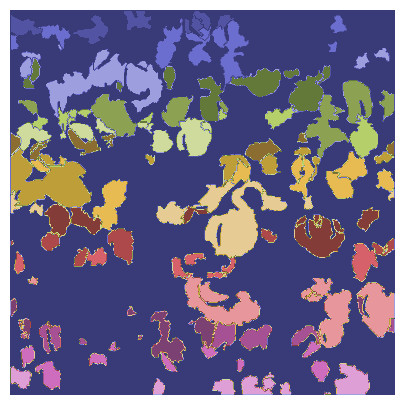

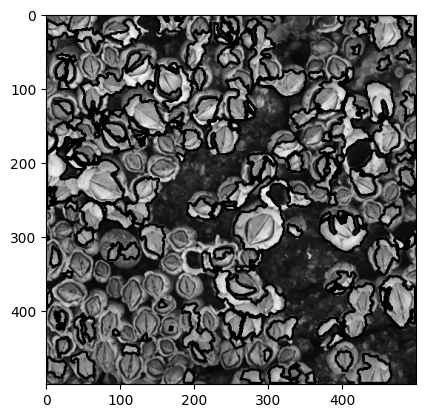

In [ ]:
# watershed Algorithm
img_array = np.array(image).astype(np.uint8)
markers = cv2.watershed(img_array, markers)

fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(markers, cmap="tab20b")
ax.axis('off')
plt.show()


labels = np.unique(markers)

coins = []
for label in labels[2:]:  

# Create a binary image in which only the area of the label is in the foreground and the rest of the image is in the background   
    target = np.where(markers == label, 255, 0).astype(np.uint8)
  
  # Perform contour extraction on the created binary image
    contours, hierarchy = cv2.findContours(
        target, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
    )
    coins.append(contours[0])

# Draw the outline
image = cv2.drawContours(image_array, coins, -1, color=(0, 23, 223), thickness=2)
plt.imshow(image, cmap ='grey')

In [73]:
print(f"The number of barnacles is {len(coins)}")

The number of barnacles is 175
